* error measure on deterministic outputs : test error is expectation over inputs of the loss where inputs are distributed according to $p(x)$
* error measure on noisy outputs : test error is expectation over inputs and outputs of the loss where inputs and outputs are distributed according to $p(x, y)$

Summary of the lecture : how to replace the size of the hypothesis set in the modified heofding inequality by a term which is more friendly and justify that, this is the VC dimension, a number which characterizes the complexity of a hypothesisset. 

More friendly because for a simple perceptron algorithm, 
the size of the hypothesis set is inifnity and thus the bound is not useful at all. 

$P(|E_{in} - E_{out}| > \epsilon) <= 2M e^{-2\epsilon^2 N}$ where M is the size of the hypothesis set and N number of training
examples.

the bound based on M can be improved.
we used the union bound to take into account  choices of different hypotheses in training phase, then we took
the worst case to compute the bound, the worst  case is where all the 'bad events' are not correlated at all(no overlapping). a bad event happen when $P(|E_{in} - E_{out}| > \epsilon)$.  we assumed that a bad event happening with a hypothesis h1 do not give us any information about the fact that a bad event happening in h2.

what is bad event concretely ?

In [93]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from lib import linreg, linreg_np

def generate_line():
    x1, y1, x2, y2 = np.random.uniform(-1, 1, size=4)
    m = (y2-y1)/(x2-x1)
    p = y1 - m * x1
    a = m
    b = -1
    c = p
    return a, b, c
    

def generate(line, nb=10):
    a, b, c = line
    x_train = np.random.uniform(-1, 1, size=(nb, 2))
    w = np.array([a, b])
    y_train = (np.dot(x_train, w) + c > 0) * 2 - 1
    return x_train, y_train

def get_line_y(x1, x2, a, b, c):
    # get y1 and y2 of corresponding x1 and x2 passing through the line defined by (ax+by+c=0)
    y1 = (- c - a * x1) / b
    y2 = (- c - a * x2) / b
    return y1, y2


def insert_ones(x):
    x = np.concatenate((x, np.ones((len(x), 1))), axis=1)
    return x

def augment(x, deg=1):
    x_feat = np.empty((len(x), deg * x.shape[1] - 1))
    k = 0
    for i in range(x.shape[1]):
        for d in range(deg):
            if i > 0 and d == 0:continue
            x_feat[:, k] = x[:, i]**d
            k += 1
    return x_feat

def plot_boundary(pred_fn, x_min, x_max, y_min, y_max, h):
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

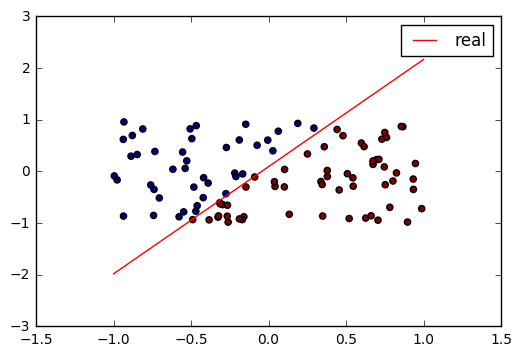

bad event!!!


In [161]:
a, b, c = generate_line()
X_test, y_test = generate((a, b, c), nb=10000)
eps = 0.01#
bad = 0
bad_stats = defaultdict(int)
nb_runs = defaultdict(int)
max_deg = 10
for _ in range(1000):
    
    deg = np.random.randint(1, max_deg) #more bad events if big deg
    nb = 100 # more bad events if nb is small
    
    X, y = generate((a, b, c), nb=nb) # more bad events if small nb of training examples (nb=10)
    #y[0:10] = -y[0:10]
    display.clear_output(wait=True)    
    fig = plt.figure()

    plt.scatter(X[:, 0], X[:, 1], c=y)

    x1, x2 = -1, 1
    y1, y2 = get_line_y(x1, x2, a, b, c)
    plt.plot([x1, x2], [y1, y2], c='red', label='real')

    x1, x2 = -1, 1
    
    X = augment(X, deg=deg)
    w = linreg_np(X, y)
    y1, y2 = get_line_y(x1, x2, a_estim, b_estim, c_estim)
    pred_fn = lambda X: (np.dot(augment(X, deg=deg), w)>0)*2-1
    #plot_boundary(pred_fn, -1, 1, -1, 1, 0.002)
    
    plt.legend()
    
    y_pred = (np.dot(X, w)>0) * 2 - 1
    E_in = (y_pred != y).mean()
    
    y_pred = (np.dot(augment(X_test, deg=deg), w)>0) * 2 - 1
    E_out = (y_pred != y_test).mean()
    
    display.display(plt.gcf())
    plt.close(fig)
    
    if np.abs(E_in - E_out) > eps:
        bad_stats[(deg, nb)] += 1        
        print('bad event!!!')
    else:
        print('good event.')
    nb_runs[(deg, nb)] += 1


In [162]:
ratio = [None] * (max_deg-1)
for k in nb_runs.keys():
    ratio[k[0] - 1] = bad_stats[k] / float(nb_runs[k])
    print(k, bad_stats[k] / float(nb_runs[k]))

(7, 100) 0.7652173913043478
(6, 100) 0.7941176470588235
(5, 100) 0.7982456140350878
(9, 100) 0.875
(4, 100) 0.7777777777777778
(3, 100) 0.7092198581560284
(2, 100) 0.5982142857142857
(1, 100) 0.8111111111111111
(8, 100) 0.9157894736842105


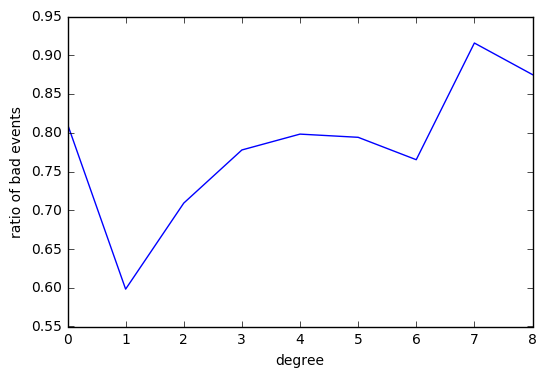

In [163]:
plt.plot(ratio)
plt.xlabel('degree')
plt.ylabel('ratio of bad events')

First concept to get : **dichotomy**. it is a function that takes a point from training set and returns -1 or +1.
given a set of training N points of binary classes, how many ways different dichotomies can we have ? or to say it in a different way, in how many ways can you classify your training points using your hypothesis set? this number is finite becasuse training data is finite, and it is a measure of complexity of your hypothesis set.

the number is at most $2^N$, this is an upperbound.

the **growth function** takes N, the number of training examples and returns the maximum number of dichotomies we can get over all possible training points of size N.

$m(N) = max_{x_1, x_2, ...x_N} |H(x_1, x_2, ..., x_N)|$  where |H(x_1, x_2, ..., x_N)| is the number of dichotmies for a given training set of size N.

$m(N) <= 2^N$

we say a hypothesis set is shattering the space if N points if $m(N) = 2^N$

the **break point** is the number of points at which you can't shatter anymore the data, that is, the smallest k such that $m(k) < 2^k$.

you cant shatter N points if N > k.

result:

* if no break point : $m(N) = 2^N$
* if any break point, then $m(N)$ is guaranted to be polynomial : good for generalization.